Projet InPoDa de Belhadj Ahmed et Benarbia Mohamed Idris en TD3

In [155]:
import pandas as pd
import re
from textblob import TextBlob
from gensim import corpora, models
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt

In [156]:
import nltk
nltk.download('punkt')

[nltk_data] Error loading punkt: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>


False

In [157]:
class InPoDa :

    def __init__(self,json_file) -> None:
        """
        Constructeur de la classe InPoDa
        """
        self.zone_atterrissage = pd.read_json(json_file)


    def nettoie_text(self):
        """
        Méthode pour néttoyer les caractères spéciaux d'une chaine
        """
        self.zone_atterrissage['text'] = self.zone_atterrissage['text'].apply(lambda x: re.sub(re.compile("[^\\w',:[ #@.,/*$+=:;]"), '', x))


    def identification_auteur(self, pub_number):
        """
        Méthode qui retourne l'auteur d'une publication passée en paramètre
        """
        return self.zone_atterrissage.loc[pub_number, 'author_id']
    

    def liste_hashtags(self, tweet_number) -> list:
        """
        Méthode qui retourne la liste des hashtags d'une publications
        """
        liste = []
        if self.zone_atterrissage.shape[0] > tweet_number >= 0:
            texte = str(self.zone_atterrissage.loc[tweet_number, 'text']).split()
            for word in texte:
                if word.startswith("#"):
                    liste.append(word)
        return liste
    
    
    def liste_mentions(self, tweet_number) -> list:
        """
        Méthode qui retourne la liste des mentions d'une publications
        """
        liste = []
        if self.zone_atterrissage.shape[0] > tweet_number >= 0:
            texte = str(self.zone_atterrissage.loc[tweet_number, 'text']).split()
            for word in texte:
                if word.startswith("@"):
                    liste.append(word)
        return liste


    def sentiments(self,tweet_number):
        """
        Méthode qui détecte le sentiment de la publication
        """
        analysis = lambda score: "positif" if score > 0 else "négatif"
        return analysis(TextBlob(str(self.zone_atterrissage.loc[tweet_number, 'text'])).sentiment.polarity)



    def K_hashtags(self,k):
        """
        Méthode qui retourne les tops K hashtags telque K est passé en paramètre
        """
        serie = []
        for tag in range(self.zone_atterrissage.shape[0]):
            serie = serie + self.liste_hashtags(tag)
        serie = pd.Series(serie).value_counts()
        return serie.head(k)


    def K_hashtags_2(self, k):
        """
        Une deuxième Méthode qui retourne les K premiers hashtags
        """
        liste_hash = [hashtag['tag'] for dict_hashtag in self.zone_atterrissage['entities'].apply(lambda x: x.get('hashtags', []) if isinstance(x,dict) else []) for hashtag in dict_hashtag]
        return pd.Series(liste_hash).value_counts().head(k)


    def top_K_utilisateurs(self, k ):
        """
        Méthode qui retourne les top K utilisateurs qui ont publié le plus
        """
        serie_users = self.zone_atterrissage['author_id']
        return serie_users.value_counts().head(k).rename_axis(None)


    def top_K_utilisateurs_mentionnes(self, k):
        """
        Méthode qui retourne les top k utilisateurs mentionnés
        """
        mentions = []
        for tweet_nbr in range(self.zone_atterrissage.shape[0]):
            mentions = mentions + self.liste_mentions(tweet_nbr)
        return pd.Series(mentions).value_counts().head(k)


    def top_K_mentions_2(self,k):
        """
        Une deuxième méthode qui retourne les top k mentions
        """
        liste_mentions = [mentions['username'] for dict_mentions in self.zone_atterrissage['entities'].apply(lambda x: x.get('mentions', []) if isinstance(x,dict) else []) for mentions in dict_mentions]
        return pd.Series(liste_mentions).value_counts().head(k)


    def nbr_tweet_per_user(self):
        """
        Méthode qui retourne le nombre de publications par utilisateur
        """
        return self.zone_atterrissage.groupby('author_id').size().reset_index(name="nbr_pub")


    def nbr_tweet_per_hashtag(self):
        """
        Méthode qui retourne le nombre de publications par hashtag
        """
        return self.K_hashtags_2(20).reset_index(name="nbr_pub").rename(columns = {'index': 'hashtags'})


    def tweets_per_user(self,user_id):
        """
        Méthode qui retourne les publications d'un utilisateur passé en paramètre
        """
        return self.zone_atterrissage[self.zone_atterrissage['author_id'] == user_id]
        

    def users_per_mention(self,mention):
        """
        Méthode qui renvoie les tweets mentionnant un utilisateur passé en paramètre
        """
        return self.zone_atterrissage[self.zone_atterrissage['text'].str.contains('@' + mention)]['author_id']


    def users_per_hashtag(self,hashtag):
        """
        Méthode qui renvoie les tweets contenant le hashtag passé en paramètre
        """
        return self.zone_atterrissage[self.zone_atterrissage['text'].str.contains('#' + hashtag)]['author_id']
    

    def bar_chart_topK_hashtags(self,k):
        top_k = self.K_hashtags(k)
        fig = plt.figure(figsize = (10, k))
        plt.bar(top_k.index, top_k.values, color ='maroon', width = 0.4)
        plt.xlabel("hashtags")
        plt.ylabel("nombre d'occurence")
        plt.title("Top K hashtags")
        plt.xticks(rotation='vertical')
        plt.show()
        
    
    def topic(self, tweet_number):
        """
        Méthode qui extrait les sujets d'un tweet
        """
        tokens = word_tokenize(str(self.zone_atterrissage.loc[tweet_number, 'text']))
        cleaned_tokens = [token.lower() for token in tokens if re.match(r'\b[a-zA-Z0-9]+\b', token) and len(token) >= 5]
        dictionary = corpora.Dictionary([cleaned_tokens])
        corpus = [dictionary.doc2bow(cleaned_tokens)]
        lda_model = models.LdaModel(corpus, num_topics=1, id2word=dictionary, passes=200)
        topics_without_probabilities = lda_model.show_topics(num_topics=5, num_words=1, formatted=False)
        return topics_without_probabilities[0][1][0][0]


    def top_k_topics(self,k):
        """
        Méthode qui renvoit les top K topics du DataFrame
        """
        topics = pd.Series([self.topic(tweet_nbr) for tweet_nbr in range(self.zone_atterrissage.shape[0])])
        return topics.value_counts().head(k)



    def nbr_tweets_per_topic(self):
        """
        Méthode qui renvoit Un tableau contenant les topics et le nombre de tweets oû il se répète
        """
        return self.top_k_topics(self.zone_atterrissage.shape[0]).reset_index(name="nbr_pub").rename(columns = {'index' : 'topics'})
    


    def bar_chart_topK_mentions(self,k):
        """
        Méthode qui déssine les top K utilisateurs mentionnés
        """
        top_k = self.top_K_mentions_2(k)
        fig = plt.figure(figsize = (10, k))
        plt.bar(top_k.index, top_k.values, color ='blue', width = 0.4)
        plt.xlabel("Mentions")
        plt.ylabel("nombre d'occurence")
        plt.title("Top K utilisateurs mentionnés")
        plt.xticks(rotation='vertical')
        plt.show()


    def bar_chart_topK_utilisateurs(self,k):
        """
        Méthode qui déssine les top K utilisateurs qui ont le plus de publications
        """
        top_k = self.top_K_utilisateurs(k)
        fig = plt.figure(figsize = (10, k))
        plt.bar(top_k.index,top_k.values, color ='purple', width = 0.4)
        plt.xlabel("Utilisateurs")
        plt.ylabel("nombre de publications publiées")
        plt.title("Top K utilisateurs avec le plus de publications")
        plt.xticks(rotation='vertical')
        plt.show()



    def bar_chart_topK_topics(self,k):
        """
        Méthode qui déssine le graphe des top k topics
        """
        top_k = self.top_k_topics(k)
        fig = plt.figure(figsize = (10, k))
        plt.bar(top_k.index, top_k.values, color ='black', width = 0.4)
        plt.xlabel("topics")
        plt.ylabel("nombre d'occurence")
        plt.title("Top K topics")
        plt.xticks(rotation='vertical')
        plt.show()


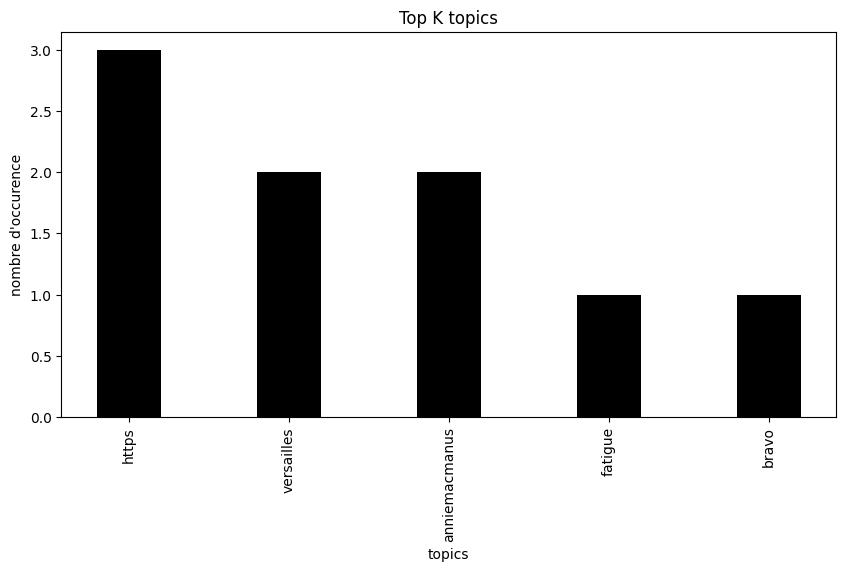

In [162]:
dataFrame = InPoDa("C:/Users/merye/Downloads/versailles_tweets_100.json")
dataFrame.nettoie_text()
#dataFrame.K_hashtags_2(20)
#dataFrame.top_K_utilisateurs(20)
#dataFrame.zone_atterrissage
#dataFrame.sentiments(1)
#dataFrame.top_K_mentions_2(20)
#dataFrame.nbr_tweet_per_user()
#dataFrame.nbr_tweet_per_hashtag()
#dataFrame.tweets_per_user(1339914264522461184)
#dataFrame.users_per_mention('leonna_julie')
#ataFrame.users_per_hashtag('CIV')
#dataFrame.bar_chart_topK_hashtags(5)
#dataFrame.nbr_tweets_per_topic()
#dataFrame.bar_chart_topK_mentions(20)
#dataFrame.bar_chart_topK_utilisateurs(5)
dataFrame.bar_chart_topK_topics(5)